# Semantic Word Vectors and Sentiment Analysis
CS 224D Assignment 1  
Spring 2015

*Complete and hand in this completed worksheet (including its outputs and any supporting code outside of the worksheet) with your assignment submission. For more details see the [assignments page](http://cs224d.stanford.edu/assignment1) on the course website.*

In this assignment, we will walk you through the process of implementing 

- A softmax function
- A simple neural network
- Back propagation
- Word2vec models

and training your own word vectors with stochastic gradient descent (SGD) for a sentiment analysis task. Please make sure to finish the corresponding problems in the problem set PDF when instructed by the worksheet.

The purpose of this assignment is to familiarize you with basic knowledge about neural networks and machine learning, including optimization and cross-validation, and help you gain proficiency in writing efficient, vectorized code.

** Please don't add or remove any code cells, as it might break our automatic grading system and affect your grade. **

**Honor Code:** I hereby agree to abide the Stanford Honor Code and that of the Computer Science Department, promise that the submitted assignment is my own work, and understand that my code is subject to plagiarism test.

**Signature**: *NeighborhoodGuo*

In [5]:
# Run some setup code for this notebook. Don't modify anything in this cell.

import random
import numpy as np
from cs224d.data_utils import *
import matplotlib.pyplot as plt

# This is a bit of magic to make matplotlib figures appear inline in the notebook
# rather than in a new window.
%matplotlib inline
plt.rcParams['figure.figsize'] = (10.0, 8.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

# Some more magic so that the notebook will reload external python modules;
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## 1. Softmax
*Please answer the first first complementary problem before starting this part.*

Given an input matrix of *N* rows and *d* columns, compute the softmax prediction for each row. That is, when the input is

    [[1,2],
    [3,4]]
    
the output of your functions should be

    [[0.2689, 0.7311],
    [0.2689, 0.7311]]

In [6]:
def softmax(x):
    """ Softmax function """
    ###################################################################
    # Compute the softmax function for the input here.                #
    # It is crucial that this function is optimized for speed because #
    # it will be used frequently in later code.                       #
    # You might find numpy functions np.exp, np.sum, np.reshape,      #
    # np.max, and numpy broadcasting useful for this task. (numpy     #
    # broadcasting documentation:                                     #
    # http://docs.scipy.org/doc/numpy/user/basics.broadcasting.html)  #
    # You should also make sure that your code works for one          #
    # dimensional inputs (treat the vector as a row), you might find  #
    # it helpful for your later problems.                             #
    ###################################################################
    
    ### YOUR CODE HERE
    x = np.array(x, np.float)
    for i in range(x.shape[0]):
        c = np.max(x[i])
        b = np.array([c])
        y = x[i] - b
        for j in range(y.shape[0]):
            x[i, j] = np.exp(y[j]) / np.sum(np.exp(y))
    ### END YOUR CODE
    
    return x

In [7]:
# Verify your softmax implementation

print "=== For autograder ==="
print softmax(np.array([[1001,1002],[3,4]]))
print softmax(np.array([[-1001,-1002]]))

=== For autograder ===
[[ 0.26894142  0.73105858]
 [ 0.26894142  0.73105858]]
[[ 0.73105858  0.26894142]]


## 2. Neural network basics

*Please answer the second complementary question before starting this part.*

In this part, you're going to implement

* A sigmoid activation function and its gradient
* A forward propagation for a simple neural network with cross-entropy cost
* A backward propagation algorithm to compute gradients for the parameters
* Gradient / derivative check

In [8]:
def sigmoid(x):
    """ Sigmoid function """
    ###################################################################
    # Compute the sigmoid function for the input here.                #
    ###################################################################
    
    ### YOUR CODE HERE
    x = np.array(x, np.float)
    b = np.array([1])
    x = 1 / (b + np.exp(-x))
    ### END YOUR CODE
    
    return x

def sigmoid_grad(f):
    """ Sigmoid gradient function """
    ###################################################################
    # Compute the gradient for the sigmoid function here. Note that   #
    # for this implementation, the input f should be the sigmoid      #
    # function value of your original input x.                        #
    ###################################################################
    
    ### YOUR CODE HERE
    b = np.array([1])
    f = f * (b - f)
    ### END YOUR CODE
    
    return f

In [9]:
# Check your sigmoid implementation
x = np.array([[1, 2], [-1, -2]])
f = sigmoid(x)
g = sigmoid_grad(f)
print "=== For autograder ==="
print f
print g

=== For autograder ===
[[ 0.73105858  0.88079708]
 [ 0.26894142  0.11920292]]
[[ 0.19661193  0.10499359]
 [ 0.19661193  0.10499359]]


Now, use the functions you just implemented, fill in the following functions to implement a neural network with one sigmoid hidden layer. You might find the handout and your answers to the second complementary problem helpful for this part.

In [10]:
# First implement a gradient checker by filling in the following functions
def gradcheck_naive(f, x):
    """ 
    Gradient check for a function f 
    - f should be a function that takes a single argument and outputs the cost and its gradients
    - x is the point (numpy array) to check the gradient at
    """ 

    rndstate = random.getstate()
    random.setstate(rndstate)  
    fx, grad = f(x) # Evaluate function value at original point
    h = 1e-4

    # Iterate over all indexes in x
    it = np.nditer(x, flags=['multi_index'], op_flags=['readwrite'])
    while not it.finished:
        ix = it.multi_index
    
        ### YOUR CODE HERE: try modifying x[ix] with h defined above to compute numerical gradients
        ### make sure you call random.setstate(rndstate) before calling f(x) each time, this will make it 
        ### possible to test cost functions with built in randomness later
        x_ix_pos = x.copy()
        x_ix_ne = x.copy()
        x_ix_pos[ix] = x[ix] + h
        x_ix_ne[ix] = x[ix] - h
        random.setstate(rndstate) 
        f_x_pos, dummy = f(x_ix_pos)
        random.setstate(rndstate)
        f_x_ne, dummy = f(x_ix_ne)
        numgrad = (f_x_pos - f_x_ne) / (2 * h)
        ### END YOUR CODE

        # Compare gradients
        reldiff = abs(numgrad - grad[ix]) / max(1, abs(numgrad), abs(grad[ix]))
        if reldiff > 1e-5:
            print "Gradient check failed."
            print "First gradient error found at index %s" % str(ix)
            print "Your gradient: %f \t Numerical gradient: %f" % (grad[ix], numgrad)
            return
    
        it.iternext() # Step to next dimension

    print "Gradient check passed!"

In [11]:
# Sanity check for the gradient checker
quad = lambda x: (np.sum(x ** 2), x * 2)

print "=== For autograder ==="
gradcheck_naive(quad, np.array(123.456))      # scalar test
gradcheck_naive(quad, np.random.randn(3,))    # 1-D test
gradcheck_naive(quad, np.random.randn(4,5))   # 2-D test

=== For autograder ===
Gradient check passed!
Gradient check passed!
Gradient check passed!


In [12]:
def forward_backward_prop(data, labels, params):
    """ Forward and backward propagation for a two-layer sigmoidal network """
    ###################################################################
    # Compute the forward propagation and for the cross entropy cost, #
    # and backward propagation for the gradients for all parameters.  #
    ###################################################################
    
    ### Unpack network parameters (do not modify)
    t = 0
    W1 = np.reshape(params[t:t+dimensions[0]*dimensions[1]], (dimensions[0], dimensions[1]))
    t += dimensions[0]*dimensions[1]
    b1 = np.reshape(params[t:t+dimensions[1]], (1, dimensions[1]))
    t += dimensions[1]
    W2 = np.reshape(params[t:t+dimensions[1]*dimensions[2]], (dimensions[1], dimensions[2]))
    t += dimensions[1]*dimensions[2]
    b2 = np.reshape(params[t:t+dimensions[2]], (1, dimensions[2]))
    
    ### YOUR CODE HERE: forward propagation
    N = data.shape[0]
    W1_trans = W1.T
    W2_trans = W2.T
    h_wb = np.zeros((N, dimensions[2]))
    z2 = np.zeros((N, dimensions[1]))
    z3 = np.zeros((N, dimensions[2]))
    a2 = np.zeros((N, dimensions[1]))
    for i in range(data.shape[0]):
        z2[i] = np.dot(W1_trans, np.reshape(data[i], (dimensions[0], 1))).T + b1
        a2[i] = sigmoid(z2[i])
        z3[i] = np.dot(W2_trans, np.reshape(a2[i], (dimensions[1], 1))).T + b2
        h_wb[i] = sigmoid(z3[i])
    cost = np.sum((h_wb.flatten() - labels.flatten()) ** 2 * 0.5) / N
    ### END YOUR CODE
    
    ### YOUR CODE HERE: backward propagation

    gradW1 = np.zeros((dimensions[0], dimensions[1]))
    gradW1_trans = np.zeros((dimensions[1], dimensions[0]))
    gradb1 = np.zeros((1, dimensions[1]))
    gradW2 = np.zeros((dimensions[1], dimensions[2]))
    gradW2_trans = np.zeros((dimensions[2], dimensions[1]))
    gradb2 = np.zeros((1, dimensions[2]))
    for i in range(N):
        delta_3 = (h_wb[i] - labels[i]) * sigmoid_grad(h_wb[i])
        delta_2 = np.dot(W2, np.reshape(delta_3, (dimensions[2], 1))).T * sigmoid_grad(a2[i])
        gradW2_trans = np.dot(np.reshape(delta_3, (dimensions[2], 1)), np.reshape(a2[i], (1, dimensions[1])))
        gradW2 += gradW2_trans.T
        gradb2 += delta_3
        gradW1_trans = np.dot(np.reshape(delta_2, (dimensions[1], 1)), np.reshape(data[i], (1, dimensions[0])))
        gradW1 += gradW1_trans.T
        gradb1 += delta_2
    gradW2 = gradW2 / N
    gradb2 = gradb2 / N
    gradW1 = gradW1 / N
    gradb1 = gradb1 / N
    ### END YOUR CODE
    
    ### Stack gradients (do not modify)
    grad = np.concatenate((gradW1.flatten(), gradb1.flatten(), gradW2.flatten(), gradb2.flatten()))
    
    return cost, grad

In [13]:
# Set up fake data and parameters for the neural network
N = 20
dimensions = [10, 5, 10]
data = np.random.randn(N, dimensions[0])   # each row will be a datum
labels = np.zeros((N, dimensions[2]))
for i in xrange(N):
    labels[i,random.randint(0,dimensions[2]-1)] = 1

params = np.random.randn((dimensions[0] + 1) * dimensions[1] + (dimensions[1] + 1) * dimensions[2], )

In [14]:
# Perform gradcheck on your neural network
print "=== For autograder ==="
gradcheck_naive(lambda params: forward_backward_prop(data, labels, params), params)

=== For autograder ===
Gradient check passed!


## 3. Word2vec

*Please answer the third complementary problem before starting this part.*

In this part you will implement the `word2vec` models and train your own word vectors with stochastic gradient descent (SGD).

In [15]:
# Implement your skip-gram and CBOW models here

# Interface to the dataset for negative sampling
dataset = type('dummy', (), {})()
def dummySampleTokenIdx():
    return random.randint(0, 4)
def getRandomContext(C):
    tokens = ["a", "b", "c", "d", "e"]
    return tokens[random.randint(0,4)], [tokens[random.randint(0,4)] for i in xrange(2*C)]
dataset.sampleTokenIdx = dummySampleTokenIdx
dataset.getRandomContext = getRandomContext

def softmaxCostAndGradient(predicted, target, outputVectors):
    """ Softmax cost function for word2vec models """
    ###################################################################
    # Implement the cost and gradients for one predicted word vector  #
    # and one target word vector as a building block for word2vec     #
    # models, assuming the softmax prediction function and cross      #
    # entropy loss.                                                   #
    # Inputs:                                                         #
    #   - predicted: numpy ndarray, predicted word vector (\hat{r} in #
    #           the written component)                                #
    #   - target: integer, the index of the target word               #
    #   - outputVectors: "output" vectors for all tokens              #
    # Outputs:                                                        #
    #   - cost: cross entropy cost for the softmax word prediction    #
    #   - gradPred: the gradient with respect to the predicted word   #
    #           vector                                                #
    #   - grad: the gradient with respect to all the other word       # 
    #           vectors                                               #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################
    
    ### YOUR CODE HERE
    target_exp = np.exp(np.dot(np.reshape(predicted, (1, predicted.shape[0])), 
                        np.reshape(outputVectors[target], (outputVectors[target].shape[0], 1))))
    all_exp = np.exp(np.dot(outputVectors, np.reshape(predicted, (predicted.shape[0], 1))))
    all_sum_exp = np.sum(all_exp)
    prob = target_exp / all_sum_exp
    cost = -np.log(prob)
    gradTarget = -predicted + prob * predicted
    
    other_exp = np.vstack([all_exp[0:target], all_exp[target + 1:len(all_exp)]]).flatten()
    other_sigmoid = other_exp / all_sum_exp
    grad = np.dot(np.reshape(other_sigmoid, (other_sigmoid.shape[0], 1)), 
                  np.reshape(predicted, (1, predicted.shape[0])))
    grad = np.vstack([grad[0:target, :], gradTarget, grad[target:grad.shape[0], :]])
    
    repmat_exp = np.tile(all_exp, (1, outputVectors.shape[1]))
    gradPred = -outputVectors[target] + np.sum(outputVectors * repmat_exp, 0) / all_sum_exp
    ### END YOUR CODE
    
    return cost, gradPred, grad

def negSamplingCostAndGradient(predicted, target, outputVectors, K=10):
    """ Negative sampling cost function for word2vec models """
    ###################################################################
    # Implement the cost and gradients for one predicted word vector  #
    # and one target word vector as a building block for word2vec     #
    # models, using the negative sampling technique. K is the sample  #
    # size. You might want to use dataset.sampleTokenIdx() to sample  #
    # a random word index.                                            #
    # Input/Output Specifications: same as softmaxCostAndGradient     #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################
    
    ### YOUR CODE HERE
    neg_indexes = [dataset.sampleTokenIdx() for k in range(K)]

    r_W = np.dot(predicted, outputVectors.T)
    sigmoid_all = sigmoid(r_W)

    cost = -np.log(sigmoid_all[target]) - np.sum(np.log(1 - sigmoid_all[neg_indexes]))
    
    gradPred = -outputVectors[target, :] * (1 - sigmoid_all[target])
    gradPred += np.dot(sigmoid_all[neg_indexes], outputVectors[neg_indexes, :])

    grad = np.zeros(np.shape(outputVectors))
    grad[target, :] = -predicted * (1 - sigmoid_all[target])

    for neg_index in neg_indexes:
        grad[neg_index,:] += predicted * sigmoid_all[neg_index]
    ### END YOUR CODE
    
    return cost, gradPred, grad

def skipgram(currentWord, C, contextWords, tokens, inputVectors, outputVectors, word2vecCostAndGradient = softmaxCostAndGradient):
    """ Skip-gram model in word2vec """
    ###################################################################
    # Implement the skip-gram model in this function.                 #         
    # Inputs:                                                         #
    #   - currrentWord: a string of the current center word           #
    #   - C: integer, context size                                    #
    #   - contextWords: list of no more than 2*C strings, the context #
    #             words                                               #
    #   - tokens: a dictionary that maps words to their indices in    #
    #             the word vector list                                #
    #   - inputVectors: "input" word vectors for all tokens           #
    #   - outputVectors: "output" word vectors for all tokens         #
    #   - word2vecCostAndGradient: the cost and gradient function for #
    #             a prediction vector given the target word vectors,  #
    #             could be one of the two cost functions you          #
    #             implemented above                                   #
    # Outputs:                                                        #
    #   - cost: the cost function value for the skip-gram model       #
    #   - grad: the gradient with respect to the word vectors         #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################
    
    ### YOUR CODE HERE
    # inputVectors VxD
    # outputVectors VxD

    # cost float
    # gradIn VxD
    # gradOut VxD
    cost = 0
    predicted = inputVectors[tokens[currentWord]]
    gradIn = np.zeros(inputVectors.shape)
    gradOut = np.zeros(outputVectors.shape)
    for contextWord in contextWords:
        target = tokens[contextWord]
        contextCost, contextGradPred, contextGrad = word2vecCostAndGradient(predicted, target, outputVectors)
        cost += contextCost
        gradIn[tokens[currentWord],:] += contextGradPred
        gradOut += contextGrad
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

def cbow(currentWord, C, contextWords, tokens, inputVectors, outputVectors, word2vecCostAndGradient = softmaxCostAndGradient):
    """ CBOW model in word2vec """
    ###################################################################
    # Implement the continuous bag-of-words model in this function.   #         
    # Input/Output specifications: same as the skip-gram model        #
    # We will not provide starter code for this function, but feel    #
    # free to reference the code you previously wrote for this        #
    # assignment!                                                     #
    ###################################################################
    
    ### YOUR CODE HERE
    in_rows = inputVectors.shape[0]
    in_cols = inputVectors.shape[1]
    
    all_context_indx = np.zeros(2 * C)
    for c in range(2 * C + 1):
        if c == C:
            target = tokens[currentWord]
        elif c < C:
            all_context_indx[c] = tokens[contextWords[c]]
        else:
            all_context_indx[c - 1] = tokens[contextWords[c - 1]]
        
    gradIn = np.zeros((in_rows, in_cols))   
    all_context_indx_list = list(np.array(all_context_indx, int))
    h = np.mean(inputVectors[all_context_indx_list], 0)

    cost, gradInTem, gradOut = word2vecCostAndGradient(h, target, outputVectors)
    for context_indx in all_context_indx:
        gradIn[context_indx] += gradInTem
    gradIn = gradIn / 2 / C
    ### END YOUR CODE
    
    return cost, gradIn, gradOut

In [16]:
# Implement a function that normalizes each row of a matrix to have unit length
def normalizeRows(x):
    """ Row normalization function """
    
    ### YOUR CODE HERE
    x = np.array(x, np.float)
    m = x.shape[0]
    n = x.shape[1]
    x_square = x ** 2
    Z = np.sqrt(np.sum(x_square, 1))
    full_Z = np.tile(np.reshape(Z, (m, 1)), (1, n))
    x = x / full_Z
    ### END YOUR CODE
    
    return x

# Test this function
print "=== For autograder ==="
print normalizeRows(np.array([[3.0,4.0],[1, 2]]))  # the result should be [[0.6, 0.8], [0.4472, 0.8944]]

=== For autograder ===
[[ 0.6         0.8       ]
 [ 0.4472136   0.89442719]]


In [17]:
# Gradient check!

def word2vec_sgd_wrapper(word2vecModel, tokens, wordVectors, dataset, C, word2vecCostAndGradient = softmaxCostAndGradient):
    batchsize = 50
    cost = 0.0
    grad = np.zeros(wordVectors.shape)
    N = wordVectors.shape[0]
    inputVectors = wordVectors[:N/2,:]
    outputVectors = wordVectors[N/2:,:]
    for i in xrange(batchsize):
        C1 = random.randint(1,C)
        centerword, context = dataset.getRandomContext(C1)
        
        if word2vecModel == skipgram:
            denom = 1
        else:
            denom = 1
        
        c, gin, gout = word2vecModel(centerword, C1, context, tokens, inputVectors, outputVectors, word2vecCostAndGradient)
        cost += c / batchsize / denom
        grad[:N/2, :] += gin / batchsize / denom
        grad[N/2:, :] += gout / batchsize / denom
        
    return cost, grad

random.seed(31415)
np.random.seed(9265)
dummy_vectors = normalizeRows(np.random.randn(10,3))
dummy_tokens = dict([("a",0), ("b",1), ("c",2),("d",3),("e",4)])
print "==== Gradient check for skip-gram ===="
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5), dummy_vectors)
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(skipgram, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)
print "\n==== Gradient check for CBOW      ===="
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5), dummy_vectors)
gradcheck_naive(lambda vec: word2vec_sgd_wrapper(cbow, dummy_tokens, vec, dataset, 5, negSamplingCostAndGradient), dummy_vectors)

print "\n=== For autograder ==="
print skipgram("c", 3, ["a", "b", "e", "d", "b", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:])
print skipgram("c", 1, ["a", "b"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], negSamplingCostAndGradient)
print cbow("a", 2, ["a", "b", "c", "a"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:])
print cbow("a", 2, ["a", "b", "a", "c"], dummy_tokens, dummy_vectors[:5,:], dummy_vectors[5:,:], negSamplingCostAndGradient)

==== Gradient check for skip-gram ====
Gradient check passed!
Gradient check passed!

==== Gradient check for CBOW      ====
Gradient check passed!
Gradient check passed!

=== For autograder ===
(array([[ 11.166109]]), array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-1.26947339, -1.36873189,  2.45158957],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.41045956,  0.18834851,  1.43272264],
       [ 0.38202831, -0.17530219, -1.33348241],
       [ 0.07009355, -0.03216399, -0.24466386],
       [ 0.09472154, -0.04346509, -0.33062865],
       [-0.13638384,  0.06258276,  0.47605228]]))
(14.095272649623691, array([[ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ],
       [-3.40325278, -2.74731195, -0.95360761],
       [ 0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.        ]]), array([[-0.49853822,  0.22876535, 

In [18]:
# Now, implement SGD

# Save parameters every a few SGD iterations as fail-safe
SAVE_PARAMS_EVERY = 1000

import glob
import os.path as op
import cPickle as pickle

def load_saved_params():
    """ A helper function that loads previously saved parameters and resets iteration start """
    st = 0
    for f in glob.glob("saved_params_*.npy"):
        iter = int(op.splitext(op.basename(f))[0].split("_")[2])
        if (iter > st):
            st = iter
            
    if st > 0:
        with open("saved_params_%d.npy" % st, "r") as f:
            params = pickle.load(f)
            state = pickle.load(f)
        return st, params, state
    else:
        return st, None, None
    
def save_params(iter, params):
    with open("saved_params_%d.npy" % iter, "w") as f:
        pickle.dump(params, f)
        pickle.dump(random.getstate(), f)

def sgd(f, x0, step, iterations, postprocessing = None, useSaved = False, PRINT_EVERY=10):
    """ Stochastic Gradient Descent """
    ###################################################################
    # Implement the stochastic gradient descent method in this        #
    # function.                                                       #
    # Inputs:                                                         #
    #   - f: the function to optimize, it should take a single        #
    #        argument and yield two outputs, a cost and the gradient  #
    #        with respect to the arguments                            #
    #   - x0: the initial point to start SGD from                     #
    #   - step: the step size for SGD                                 #
    #   - iterations: total iterations to run SGD for                 #
    #   - postprocessing: postprocessing function for the parameters  #
    #        if necessary. In the case of word2vec we will need to    #
    #        normalize the word vectors to have unit length.          #
    #   - PRINT_EVERY: specifies every how many iterations to output  #
    # Output:                                                         #
    #   - x: the parameter value after SGD finishes                   #
    ###################################################################
    
    # Anneal learning rate every several iterations
    ANNEAL_EVERY = 20000
    
    if useSaved:
        start_iter, oldx, state = load_saved_params()
        if start_iter > 0:
            x0 = oldx;
            step *= 0.5 ** (start_iter / ANNEAL_EVERY)
            
        if state:
            random.setstate(state)
    else:
        start_iter = 0
    
    x = x0
    
    if not postprocessing:
        postprocessing = lambda x: x
    
    expcost = None
    costs = np.zeros(iterations / PRINT_EVERY)
    
    for iter in xrange(start_iter + 1, iterations + 1):
        ### YOUR CODE HERE
        ### Don't forget to apply the postprocessing after every iteration!
        ### You might want to print the progress every few iterations.
        cost, grad = f(x)
        bat_grad = -step * grad
        x += bat_grad
        x = postprocessing(x)
        
        if iter % PRINT_EVERY == 0:
            print "iter", iter, "cost", cost
            costs[iter / PRINT_EVERY - 1] = cost
        ### END YOUR CODE
        
        if iter % SAVE_PARAMS_EVERY == 0 and useSaved:
            save_params(iter, x)
            
        if iter % ANNEAL_EVERY == 0:
            step *= 0.5
            
            
    np.savetxt('costs.txt', costs, fmt='%f')
    return x

**Show time! Now we are going to load some real data and train word vectors with everything you just implemented!**

We are going to use the Stanford Sentiment Treebank (SST) dataset to train word vectors, and later apply them to a simple sentiment analysis task.

In [19]:
# Load some data and initialize word vectors

# Reset the random seed to make sure that everyone gets the same results
random.seed(314)
dataset = StanfordSentiment()
tokens = dataset.tokens()
nWords = len(tokens)

# We are going to train 10-dimensional vectors for this assignment
dimVectors = 10

# Context size
C = 5

In [89]:
# Train word vectors (this could take a while!)

# Reset the random seed to make sure that everyone gets the same results
random.seed(31415)
np.random.seed(9265)
wordVectors = np.concatenate(((np.random.rand(nWords, dimVectors) - .5) / dimVectors, 
                              np.zeros((nWords, dimVectors))), axis=0)
wordVectors0 = sgd(lambda vec: word2vec_sgd_wrapper(skipgram, tokens, vec, dataset, C, negSamplingCostAndGradient), 
                   wordVectors, 0.3, 40000, None, True, PRINT_EVERY=10)
# sanity check: cost at convergence should be around or below 10

# sum the input and output word vectors
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])

print "\n=== For autograder ==="
checkWords = ["the", "a", "an", "movie", "ordinary", "but", "and"]
checkIdx = [tokens[word] for word in checkWords]
checkVecs = wordVectors[checkIdx, :]
print checkVecs

iter 10 cost 23.4837977061
iter 20 cost 18.9090289192
iter 30 cost 22.8738513566
iter 40 cost 21.3489762294
iter 50 cost 28.0586360192
iter 60 cost 28.05852381
iter 70 cost 26.6861227175
iter 80 cost 19.5190280472
iter 90 cost 22.8739074985
iter 100 cost 19.8240352379
iter 110 cost 22.7214242491
iter 120 cost 21.5014047749
iter 130 cost 22.5687589635
iter 140 cost 23.3313831705
iter 150 cost 22.721349141
iter 160 cost 18.4516454684
iter 170 cost 22.111230845
iter 180 cost 22.4160286728
iter 190 cost 20.2813473953
iter 200 cost 22.568762022
iter 210 cost 24.398680183
iter 220 cost 18.9091138789
iter 230 cost 22.8736598192
iter 240 cost 22.4166500621
iter 250 cost 20.7389134488
iter 260 cost 20.5862205939
iter 270 cost 21.9589842764
iter 280 cost 20.1293405563
iter 290 cost 22.5689173252
iter 300 cost 18.2996449743
iter 310 cost 23.3310269343
iter 320 cost 22.7215372065
iter 330 cost 23.7881630539
iter 340 cost 22.5693124193
iter 350 cost 20.5862824185
iter 360 cost 19.6715789957
iter 37

wordVectors0Shape (39078, 10)


(-0.10423499281960062, 0.17447891706738783)

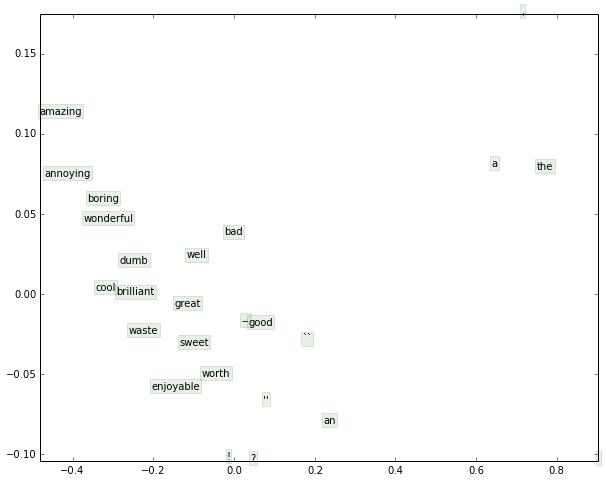

In [20]:
# Visualize the word vectors you trained
wordVectors0 = np.loadtxt('wordVectors0.txt')
#np.savetxt('wordVectors0.txt', wordVectors0, fmt='%f')
print "wordVectors0Shape", wordVectors0.shape
_, wordVectors0, _ = load_saved_params()
wordVectors = (wordVectors0[:nWords,:] + wordVectors0[nWords:,:])
visualizeWords = ["the", "a", "an", ",", ".", "?", "!", "``", "''", "--", "good", "great", "cool", "brilliant", "wonderful", "well", "amazing", "worth", "sweet", "enjoyable", "boring", "bad", "waste", "dumb", "annoying"]
visualizeIdx = [tokens[word] for word in visualizeWords]
visualizeVecs = wordVectors[visualizeIdx, :]
temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
U,S,V = np.linalg.svd(covariance)
coord = temp.dot(U[:,0:2]) 

for i in xrange(len(visualizeWords)):
    plt.text(coord[i,0], coord[i,1], visualizeWords[i], bbox=dict(facecolor='green', alpha=0.1))
    
plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

## 4. Sentiment Analysis

Now, with the word vectors you trained, we are going to perform a simple sentiment analysis.

For each sentence in the Stanford Sentiment Treebank dataset, we are going to use the average of all the word vectors in that sentence as its feature, and try to predict the sentiment level of the said sentence. The sentiment level of the phrases are represented as real values in the original dataset, here we'll just use five classes:

    "very negative", "negative", "neutral", "positive", "very positive"
    
which are represented by 0 to 4 in the code, respectively.

For this part, you will learn to train a softmax regressor with SGD, and perform train/dev validation to improve generalization of your regressor.

In [101]:
# Now, implement some helper functions

def getSentenceFeature(tokens, wordVectors, sentence):
    """ Obtain the sentence feature for sentiment analysis by averaging its word vectors """
    ###################################################################
    # Implement computation for the sentence features given a         #
    # sentence.                                                       #
    # Inputs:                                                         #
    #   - tokens: a dictionary that maps words to their indices in    #
    #             the word vector list                                #
    #   - wordVectors: word vectors for all tokens                    #
    #   - sentence: a list of words in the sentence of interest       #
    # Output:                                                         #
    #   - sentVector: feature vector for the sentence                 #
    ###################################################################
    
    sentVector = np.zeros((wordVectors.shape[1],))
    
    ### YOUR CODE HERE
    # wordVectors: V X N
    for word in sentence:
        wordIndex = tokens[word]
        sentVector += wordVectors[wordIndex]
    sentVector = sentVector / len(sentence)
    ### END YOUR CODE
    
    return sentVector

def softmaxRegression(features, labels, weights, regularization = 0.0, nopredictions = False):
    """ Softmax Regression """
    ###################################################################
    # Implement softmax regression with weight regularization.        #
    # Inputs:                                                         #
    #   - features: feature vectors, each row is a feature vector     #
    #   - labels: labels corresponding to the feature vectors         #
    #   - weights: weights of the regressor                           #
    #   - regularization: L2 regularization constant                  #
    # Output:                                                         #
    #   - cost: cost of the regressor                                 #
    #   - grad: gradient of the regressor cost with respect to its    #
    #           weights                                               #
    #   - pred: label predictions of the regressor (you might find    #
    #           np.argmax helpful)                                    #
    ###################################################################
    
    prob = softmax(features.dot(weights))
    if len(features.shape) > 1:
        N = features.shape[0]
    else:
        N = 1
    # A vectorized implementation of    1/N * sum(cross_entropy(x_i, y_i)) + 1/2*|w|^2
    cost = np.sum(-np.log(prob[range(N), labels])) / N 
    cost += 0.5 * regularization * np.sum(weights ** 2)
    
    
    ### YOUR CODE HERE: compute the gradients and predictions
    # features: #features X #attributes
    # weights: #attributes X #classes
    # prob: #features X #classes
    prob_copy = prob.copy()
    prob_copy[range(N), labels] -= 1
    prob_copy = prob_copy / N
    grad = np.dot(features.T, prob_copy) + regularization * weights
    pred = np.argmax(prob, axis = 1)
    ### END YOUR CODE
    
    if nopredictions:
        return cost, grad
    else:
        return cost, grad, pred

def precision(y, yhat):
    """ Precision for classifier """
    assert(y.shape == yhat.shape)
    return np.sum(y == yhat) * 100.0 / y.size

def softmax_wrapper(features, labels, weights, regularization = 0.0):
    cost, grad, _ = softmaxRegression(features, labels, weights, regularization)
    return cost, grad

In [102]:
# Gradient check always comes first
random.seed(314159)
np.random.seed(265)
dummy_weights = 0.1 * np.random.randn(dimVectors, 5)
dummy_features = np.zeros((10, dimVectors))
dummy_labels = np.zeros((10,), dtype=np.int32)    
for i in xrange(10):
    words, dummy_labels[i] = dataset.getRandomTrainSentence()
    dummy_features[i, :] = getSentenceFeature(tokens, wordVectors, words)
print "==== Gradient check for softmax regression ===="
gradcheck_naive(lambda weights: softmaxRegression(dummy_features, dummy_labels, weights, 1.0, nopredictions = True), dummy_weights)

print "\n=== For autograder ==="
print softmaxRegression(dummy_features, dummy_labels, dummy_weights, 1.0)

==== Gradient check for softmax regression ====
Gradient check passed!

=== For autograder ===
(1.9087572203226313, array([[ 0.13471085,  0.0104175 ,  0.06464052,  0.14678234,  0.07468882],
       [-0.11082732, -0.0753506 ,  0.00940976,  0.09072251,  0.02397455],
       [ 0.02857999, -0.07050319,  0.00609608, -0.00242226, -0.08065193],
       [ 0.1165844 ,  0.23443669, -0.03104372, -0.05643964, -0.03242766],
       [ 0.16402121,  0.07514553, -0.06366103,  0.00533061, -0.24784793],
       [ 0.00873329, -0.03116552,  0.28757243,  0.11892055,  0.09353462],
       [-0.14699131, -0.16446357, -0.23492789, -0.14272223,  0.08556511],
       [ 0.10900431,  0.06290933, -0.03857583,  0.10949341, -0.11392697],
       [-0.25459777,  0.17492415,  0.07520622,  0.09168167,  0.02080977],
       [-0.05482908, -0.0023394 ,  0.10969091, -0.06085632,  0.10433387]]), array([0, 0, 0, 0, 0, 0, 0, 0, 0, 1]))


In [106]:
# Try different regularizations and pick the best!

### YOUR CODE HERE

regularization = 0.00003 # try 0.0, 0.00001, 0.00003, 0.0001, 0.0003, 0.001, 0.003, 0.01 and pick the best

### END YOUR CODE

random.seed(3141)
np.random.seed(59265)
weights = np.random.randn(dimVectors, 5)

trainset = dataset.getTrainSentences()
nTrain = len(trainset)
trainFeatures = np.zeros((nTrain, dimVectors))
trainLabels = np.zeros((nTrain,), dtype=np.int32)

for i in xrange(nTrain):
    words, trainLabels[i] = trainset[i]
    trainFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)
    
# We will do batch optimization
weights = sgd(lambda weights: softmax_wrapper(trainFeatures, trainLabels, weights, regularization), weights, 3.0, 10000, PRINT_EVERY=100)

# Prepare dev set features
devset = dataset.getDevSentences()
nDev = len(devset)
devFeatures = np.zeros((nDev, dimVectors))
devLabels = np.zeros((nDev,), dtype=np.int32)

for i in xrange(nDev):
    words, devLabels[i] = devset[i]
    devFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)
    
_, _, pred = softmaxRegression(devFeatures, devLabels, weights)
print "Dev precision (%%): %f" % precision(devLabels, pred)

iter 100 cost 1.57139536628
iter 200 cost 1.57097211637
iter 300 cost 1.57057549891
iter 400 cost 1.57020344464
iter 500 cost 1.56985406715
iter 600 cost 1.56952564573
iter 700 cost 1.56921660977
iter 800 cost 1.56892552474
iter 900 cost 1.56865107943
iter 1000 cost 1.5683920745
iter 1100 cost 1.56814741207
iter 1200 cost 1.56791608634
iter 1300 cost 1.56769717512
iter 1400 cost 1.56748983219
iter 1500 cost 1.56729328033
iter 1600 cost 1.56710680508
iter 1700 cost 1.56692974909
iter 1800 cost 1.56676150702
iter 1900 cost 1.56660152083
iter 2000 cost 1.5664492757
iter 2100 cost 1.56630429614
iter 2200 cost 1.5661661426
iter 2300 cost 1.56603440836
iter 2400 cost 1.5659087167
iter 2500 cost 1.56578871831
iter 2600 cost 1.56567408904
iter 2700 cost 1.56556452773
iter 2800 cost 1.56545975431
iter 2900 cost 1.56535950808
iter 3000 cost 1.56526354613
iter 3100 cost 1.56517164186
iter 3200 cost 1.56508358373
iter 3300 cost 1.56499917404
iter 3400 cost 1.56491822782
iter 3500 cost 1.5648405718

In [107]:
# Write down the best regularization and accuracy you found
# sanity check: your accuracy should be around or above 30%

### YOUR CODE HERE

BEST_REGULARIZATION = 0.000003
BEST_ACCURACY = 30.881017

### END YOUR CODE

print "=== For autograder ===\n%g\t%g" % (BEST_REGULARIZATION, BEST_ACCURACY)

=== For autograder ===
3e-06	30.881


In [108]:
# Test your findings on the test set

testset = dataset.getTestSentences()
nTest = len(testset)
testFeatures = np.zeros((nTest, dimVectors))
testLabels = np.zeros((nTest,), dtype=np.int32)

for i in xrange(nTest):
    words, testLabels[i] = testset[i]
    testFeatures[i, :] = getSentenceFeature(tokens, wordVectors, words)
    
_, _, pred = softmaxRegression(testFeatures, testLabels, weights)
print "=== For autograder ===\nTest precision (%%): %f" % precision(testLabels, pred)

=== For autograder ===
Test precision (%): 28.235294


#### Extra Credit

Train your own classifier for sentiment analysis! We will not provide any starter code for this part, but you can feel free to reuse the code you've written before, or write some new code for this task. Also feel free to refer to the code we provided you with to see how we scaffolded training for you.

Try to contain all of your code in one code block. You could start by using multiple blocks, then paste code together and remove unnecessary blocks. Report, as the last two lines of the output of your block, the dev set accuracy and test set accuracy you achieved, in the format we used above.

*Note: no credits will be given for this part if you use the dev or test sets for training, or if you fine-tune your regularization or other hyperparameters on the test set.*

In [ ]:
### YOUR CODE HERE

### END YOU CODE


_, _, pred = softmaxRegression(devFeatures, devLabels, weights)
print "=== For autograder ===\nDev precision (%%): %f" % precision(devLabels, pred)
_, _, pred = softmaxRegression(testFeatures, testLabels, weights)
print "Test precision (%%): %f" % precision(testLabels, pred)